In [1]:
%load_ext autoreload
%autoreload 2
import astropy.units as u
import astropy.constants as const
from astroduet.bbmag import bb_abmag_fluence, bb_abmag, gettempbb
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

import astroduet.config as config
from astroduet.background import background_pixel_rate

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
plt.rcParams['figure.figsize'] = [15,8]

In [3]:
# Telescope setup, just used for bandpass here
duet = config.Telescope()
duet.info()
bandone=duet.bandpass1
bandtwo = duet.bandpass2

Physical Entrance Pupil: 26.0 cm
Effective EPD:  24.2 cm
Effective Area:  4.6e+02 cm2
Pixel size:   6.4 arcsec
Transmission Efficiency:  0.82
PSF FWHM:   4.3 arcsec

Pointing jitter: 5.0 arcsec
Effective PSF FWHM: 6.6 arcsec

Band 1: {'eff_wave': <Quantity 213.60141673 nm>, 'eff_width': <Quantity 53.32814342 nm>}
Bandpass 1: [186.93734502 240.26548844] nm
Band 2: {'eff_wave': <Quantity 291.30506026 nm>, 'eff_width': <Quantity 68.16239088 nm>}
Bandpass 2: [257.22386482 325.3862557 ] nm


In [4]:
# Blackbody settings
bbtab = Table([[1.e4, 2.e4, 5.e4, 1.e5, 2.e5]*u.K,np.zeros(5),np.zeros(5)], names=('temp','mag_D1','mag_D2'))
snr = np.arange(5,100)
stat_err = 2.5*np.log10(1.+1./snr)
sys_err = [0.05,0.1,0.2] # Random guess...

In [5]:
# Get blackbody magnitudes (scale is random)
for i, temp in enumerate(bbtab['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab['mag_D1'][i], bbtab['mag_D2'][i] = mag1, mag2

In [6]:
# Fit blackbody temperatures:
bbtemps = np.zeros([len(sys_err),len(bbtab['temp']),len(snr),2])*u.K
for k, syserr in enumerate(sys_err):
    for i,temp in enumerate(bbtab['temp']):
        for j,staterr in enumerate(stat_err):
            fittemp, fittemperr = gettempbb(bandone=bandone, bandtwo=bandtwo,
                                        magone=bbtab['mag_D1'][i]*u.ABmag, magtwo=bbtab['mag_D2'][i]*u.ABmag,
                                        magone_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag,
                                        magtwo_err=np.sqrt(staterr**2 + syserr**2)*u.ABmag, bbtemp_init=temp)
            bbtemps[k,i,j] = fittemp, fittemperr

In [7]:
# DUET colors as function of temperature
bbtab_large = Table([np.geomspace(5e3,5e5,num=100)*u.K,np.zeros(100),np.zeros(100),np.zeros(100)], names=('temp','mag_D1','mag_D2','deltamag'))
for i, temp in enumerate(bbtab_large['temp'].quantity):
    mag1, mag2 = bb_abmag(bbtemp=temp, bandone=bandone, bandtwo=bandtwo, swiftmag=20*u.ABmag, val=True)
    bbtab_large['mag_D1'][i], bbtab_large['mag_D2'][i], bbtab_large['deltamag'][i] = mag1, mag2, mag1-mag2

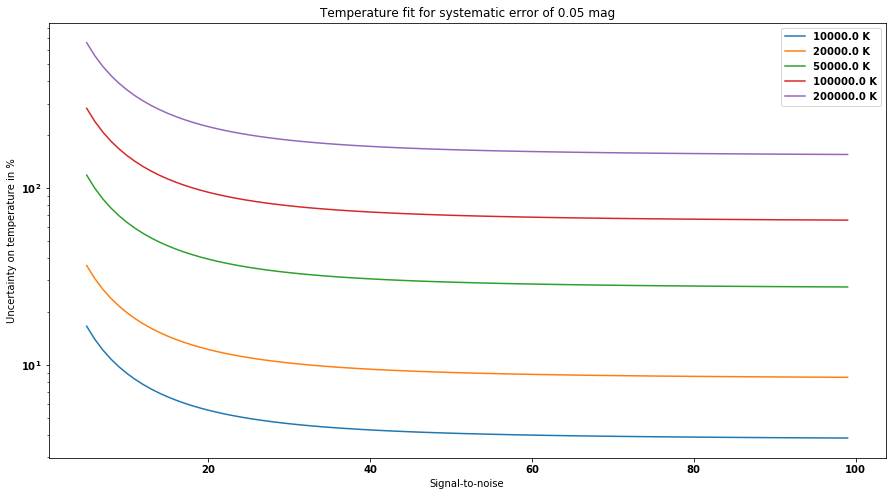

In [8]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[0,i,:,1]/bbtemps[0,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Uncertainty on temperature in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.05 mag')
plt.show()

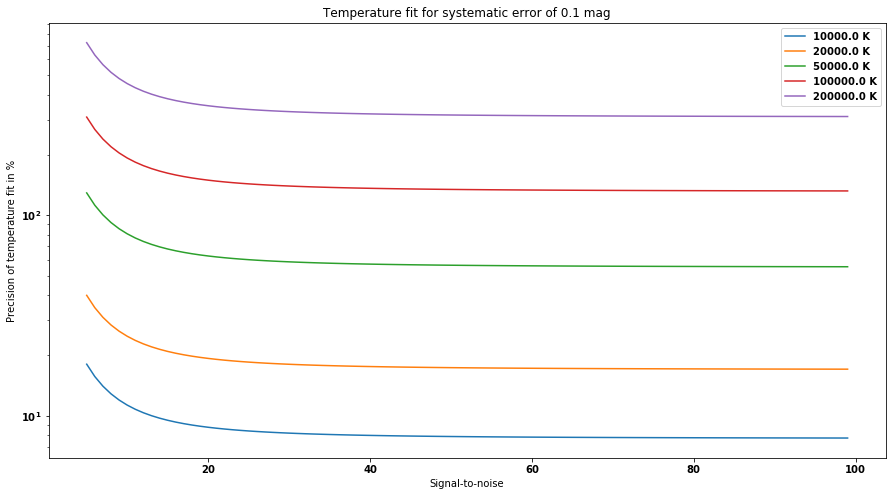

In [9]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[1,i,:,1]/bbtemps[1,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.1 mag')
plt.show()

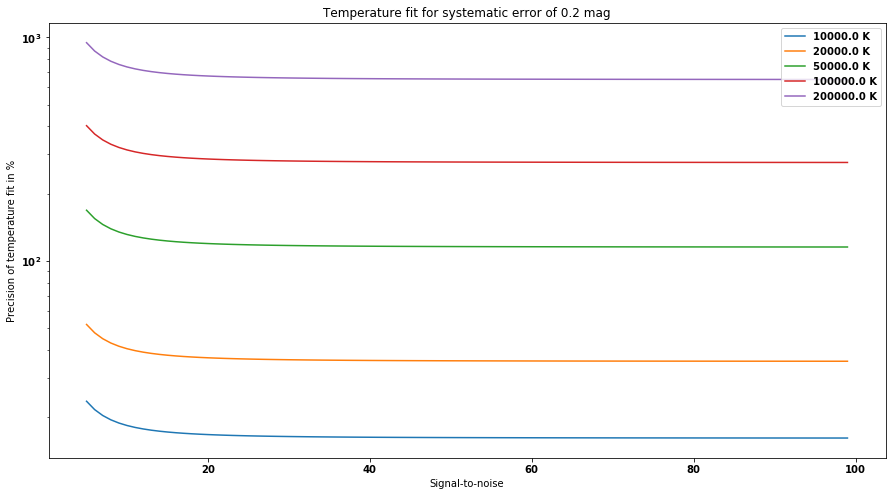

In [10]:
for i,temp in enumerate(bbtab['temp']):
    #plt.errorbar(snr,bbtemps[i,:,0],yerr=bbtemps[i,:,1])
    plt.plot(snr,bbtemps[2,i,:,1]/bbtemps[2,i,:,0]*100,label=str(temp)+' K')

#plt.ylim(0,1e6)
plt.yscale('log')
plt.ylabel('Precision of temperature fit in %')
plt.xlabel('Signal-to-noise')
plt.legend()
plt.title('Temperature fit for systematic error of 0.2 mag')
plt.show()

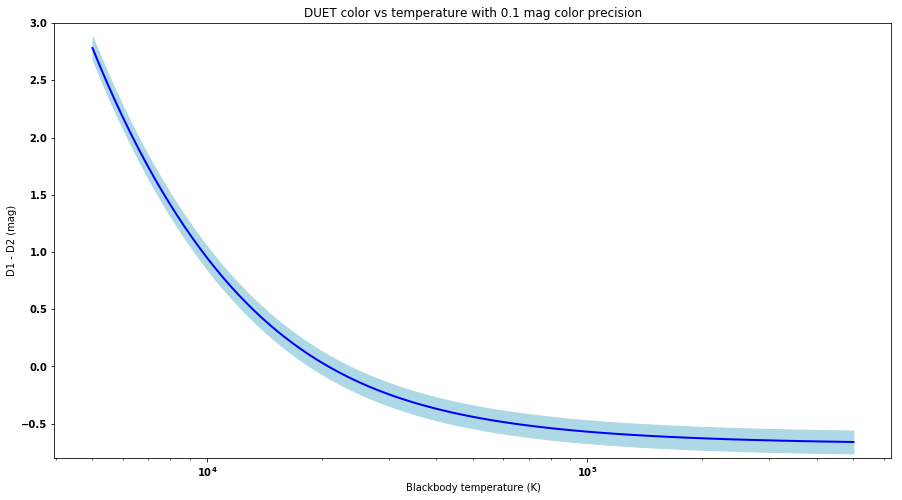

In [11]:
plt.fill_between(bbtab_large['temp'], bbtab_large['deltamag']-0.1, bbtab_large['deltamag']+0.1, color='lightblue')
plt.plot(bbtab_large['temp'],bbtab_large['deltamag'],linewidth=2, color='blue')

plt.xlabel('Blackbody temperature (K)')
plt.ylabel('D1 - D2 (mag)')
plt.ylim(-0.8,3)
#plt.xlim(1e4,5e5)
plt.xscale('log')
plt.title('DUET color vs temperature with 0.1 mag color precision')
plt.show()